In [1]:
# Cell 1: Imports and Basic Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import swin_t
import numpy as np
import cv2
from pathlib import Path
import random
from sklearn.metrics import accuracy_score, f1_score
import time
import os
from collections import defaultdict

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seeds(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
VRAM: 12.0 GB


In [2]:
# Cell 2: Configuration and Data Loading
class Config:
    # Dataset paths
    DATA_ROOT = Path(r"C:\Users\MVI_lab_2\Desktop\Steel\GC10-DET")
    
    # Model settings
    IMAGE_SIZE = 224
    PROJECTION_DIM = 64  # Small for testing
    NUM_CLASSES = 10
    
    # Training settings
    BATCH_SIZE = 4  # Very small for RTX 3060
    CONTRASTIVE_EPOCHS = 3  # Very short for testing
    CLASSIFICATION_EPOCHS = 5  # Very short for testing
    LEARNING_RATE = 1e-4
    TEMPERATURE = 0.5

config = Config()

def load_gc10_data():
    """Load GC10-DET dataset"""
    image_paths = []
    labels = []
    class_names = []
    
    print(f"Loading data from: {config.DATA_ROOT}")
    
    # Get all class folders
    for class_folder in sorted(config.DATA_ROOT.iterdir()):
        if class_folder.is_dir():
            class_names.append(class_folder.name)
            class_idx = len(class_names) - 1
            
            # Get all images in this class
            images = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.png'))
            print(f"Class {class_folder.name}: {len(images)} images")
            
            for img_path in images[:50]:  # Limit to 50 images per class for testing
                image_paths.append(img_path)
                labels.append(class_idx)
    
    print(f"Total classes: {len(class_names)}")
    print(f"Total images loaded: {len(image_paths)}")
    print(f"Class names: {class_names}")
    
    return image_paths, labels, class_names

# Load the data
image_paths, labels, class_names = load_gc10_data()
config.NUM_CLASSES = len(class_names)

Loading data from: C:\Users\MVI_lab_2\Desktop\Steel\GC10-DET
Class 1: 219 images
Class 10: 150 images
Class 2: 273 images
Class 3: 226 images
Class 4: 289 images
Class 5: 204 images
Class 6: 651 images
Class 7: 216 images
Class 8: 31 images
Class 9: 53 images
Class lable: 0 images
Total classes: 11
Total images loaded: 481
Class names: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'lable']


In [3]:
# Cell 3: Clean Data and Create Splits
from sklearn.model_selection import train_test_split

def clean_and_split_data(image_paths, labels, class_names):
    """Clean data and create train/val splits"""
    
    # Remove empty classes
    clean_paths = []
    clean_labels = []
    clean_class_names = []
    label_mapping = {}
    
    # Group by class
    class_data = defaultdict(list)
    for path, label in zip(image_paths, labels):
        class_data[label].append(path)
    
    # Keep only classes with at least 10 images
    new_label = 0
    for old_label, paths in class_data.items():
        if len(paths) >= 10:  # Minimum 10 images per class
            class_name = class_names[old_label]
            print(f"Keeping class {class_name}: {len(paths)} images")
            
            clean_class_names.append(class_name)
            label_mapping[old_label] = new_label
            
            for path in paths:
                clean_paths.append(path)
                clean_labels.append(new_label)
            
            new_label += 1
        else:
            print(f"Removing class {class_names[old_label]}: only {len(paths)} images")
    
    print(f"\nFinal dataset:")
    print(f"Classes: {len(clean_class_names)}")
    print(f"Total images: {len(clean_paths)}")
    print(f"Class names: {clean_class_names}")
    
    # Create train/val splits
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        clean_paths, clean_labels, 
        test_size=0.3, 
        stratify=clean_labels, 
        random_state=42
    )
    
    print(f"\nData splits:")
    print(f"Train: {len(train_paths)} images")
    print(f"Val: {len(val_paths)} images")
    
    # Print class distribution
    train_dist = np.bincount(train_labels)
    val_dist = np.bincount(val_labels)
    
    print(f"\nClass distribution:")
    for i, class_name in enumerate(clean_class_names):
        print(f"Class {class_name}: Train={train_dist[i]}, Val={val_dist[i]}")
    
    return train_paths, val_paths, train_labels, val_labels, clean_class_names

# Clean and split the data
train_paths, val_paths, train_labels, val_labels, clean_class_names = clean_and_split_data(
    image_paths, labels, class_names
)

# Update config
config.NUM_CLASSES = len(clean_class_names)
print(f"\nUpdated number of classes: {config.NUM_CLASSES}")

Keeping class 1: 50 images
Keeping class 10: 50 images
Keeping class 2: 50 images
Keeping class 3: 50 images
Keeping class 4: 50 images
Keeping class 5: 50 images
Keeping class 6: 50 images
Keeping class 7: 50 images
Keeping class 8: 31 images
Keeping class 9: 50 images

Final dataset:
Classes: 10
Total images: 481
Class names: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

Data splits:
Train: 336 images
Val: 145 images

Class distribution:
Class 1: Train=35, Val=15
Class 10: Train=35, Val=15
Class 2: Train=35, Val=15
Class 3: Train=35, Val=15
Class 4: Train=35, Val=15
Class 5: Train=35, Val=15
Class 6: Train=35, Val=15
Class 7: Train=35, Val=15
Class 8: Train=21, Val=10
Class 9: Train=35, Val=15

Updated number of classes: 10


In [4]:
# Cell 4: Dataset Class
class SteelDefectDataset(Dataset):
    def __init__(self, image_paths, labels, mode='classification'):
        self.image_paths = image_paths
        self.labels = labels
        self.mode = mode
        
        # Basic transform for classification
        self.basic_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        # Augmented transform for contrastive learning
        self.contrastive_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.3),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        try:
            # Load image
            image_path = str(self.image_paths[idx])
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Cannot load image: {image_path}")
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = self.labels[idx]
            
            if self.mode == 'contrastive':
                # Return two augmented views for contrastive learning
                view1 = self.contrastive_transform(image)
                view2 = self.contrastive_transform(image)
                return view1, view2, label
            else:
                # Return single view for classification
                image_tensor = self.basic_transform(image)
                return image_tensor, label
                
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return dummy data in case of error
            dummy_tensor = torch.zeros(3, config.IMAGE_SIZE, config.IMAGE_SIZE)
            if self.mode == 'contrastive':
                return dummy_tensor, dummy_tensor, 0
            else:
                return dummy_tensor, 0

# Test dataset creation
print("Creating datasets...")
train_dataset_contrastive = SteelDefectDataset(train_paths, train_labels, mode='contrastive')
train_dataset_classification = SteelDefectDataset(train_paths, train_labels, mode='classification')
val_dataset = SteelDefectDataset(val_paths, val_labels, mode='classification')

print(f"Contrastive train dataset: {len(train_dataset_contrastive)} samples")
print(f"Classification train dataset: {len(train_dataset_classification)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")

# Test loading one sample
print("\nTesting dataset loading...")
try:
    # Test contrastive sample
    view1, view2, label = train_dataset_contrastive[0]
    print(f"Contrastive sample - View1: {view1.shape}, View2: {view2.shape}, Label: {label}")
    
    # Test classification sample
    image, label = train_dataset_classification[0]
    print(f"Classification sample - Image: {image.shape}, Label: {label}")
    print("Dataset loading test successful!")
except Exception as e:
    print(f"Dataset loading test failed: {e}")

Creating datasets...
Contrastive train dataset: 336 samples
Classification train dataset: 336 samples
Validation dataset: 145 samples

Testing dataset loading...
Contrastive sample - View1: torch.Size([3, 224, 224]), View2: torch.Size([3, 224, 224]), Label: 7
Classification sample - Image: torch.Size([3, 224, 224]), Label: 7
Dataset loading test successful!


In [5]:
# Cell 5: Simplified Swin Transformer Model
class SimpleSwinContrastive(nn.Module):
    def __init__(self, num_classes=10, projection_dim=64):
        super().__init__()
        
        # Use lightweight Swin Tiny
        self.backbone = swin_t(weights='DEFAULT')
        
        # Remove the final classification head
        self.feature_dim = self.backbone.head.in_features
        self.backbone.head = nn.Identity()
        
        print(f"Backbone feature dimension: {self.feature_dim}")
        
        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )
        
        # Classification head
        self.classification_head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.feature_dim, num_classes)
        )
        
        self.mode = 'contrastive'  # 'contrastive' or 'classification'
    
    def forward(self, x1, x2=None):
        if self.mode == 'contrastive':
            # Extract features for both views
            features1 = self.backbone(x1)
            features2 = self.backbone(x2)
            
            # Project to contrastive space and normalize
            proj1 = F.normalize(self.projection_head(features1), dim=1)
            proj2 = F.normalize(self.projection_head(features2), dim=1)
            
            # Concatenate projections
            return torch.cat([proj1, proj2], dim=0)
        else:
            # Classification mode
            features = self.backbone(x1)
            return self.classification_head(features)
    
    def set_mode(self, mode):
        self.mode = mode

# NT-Xent Loss for contrastive learning
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
    
    def forward(self, projections, labels):
        device = projections.device
        batch_size = projections.shape[0] // 2
        
        # Create similarity matrix
        similarity_matrix = torch.mm(projections, projections.t())
        
        # Create labels for positive pairs
        labels = labels.repeat(2)
        labels_matrix = labels.unsqueeze(0) == labels.unsqueeze(1)
        
        # Remove diagonal (self-similarity)
        mask = torch.eye(labels_matrix.shape[0], device=device).bool()
        labels_matrix = labels_matrix & ~mask
        
        # Apply temperature scaling
        similarity_matrix = similarity_matrix / self.temperature
        
        # Numerical stability
        similarity_matrix = similarity_matrix - similarity_matrix.max(dim=1, keepdim=True)[0].detach()
        
        # Calculate loss
        exp_sim = torch.exp(similarity_matrix)
        exp_sim = exp_sim * (~mask).float()  # Remove diagonal
        
        pos_sim = exp_sim * labels_matrix.float()
        neg_sim = exp_sim.sum(dim=1, keepdim=True)
        
        loss = -torch.log(pos_sim.sum(dim=1) / neg_sim.squeeze()).mean()
        
        return loss

# Create model
print("Creating model...")
model = SimpleSwinContrastive(num_classes=config.NUM_CLASSES, projection_dim=config.PROJECTION_DIM)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024**2:.1f} MB")

# Test model forward pass
print("\nTesting model...")
model.eval()
with torch.no_grad():
    # Test contrastive mode
    model.set_mode('contrastive')
    dummy_input = torch.randn(2, 3, 224, 224).to(device)
    contrastive_output = model(dummy_input, dummy_input)
    print(f"Contrastive output shape: {contrastive_output.shape}")
    
    # Test classification mode
    model.set_mode('classification')
    classification_output = model(dummy_input)
    print(f"Classification output shape: {classification_output.shape}")

print("Model creation successful!")

Creating model...


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to C:\Users\MVI_lab_2/.cache\torch\hub\checkpoints\swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 72.1MB/s] 


Backbone feature dimension: 768
Total parameters: 27,740,868
Trainable parameters: 27,740,868
Model size: 105.8 MB

Testing model...
Contrastive output shape: torch.Size([4, 64])
Classification output shape: torch.Size([2, 10])
Model creation successful!


In [6]:
# Cell 6: Create Data Loaders
def create_data_loaders():
    """Create data loaders with appropriate batch sizes"""
    
    # Create data loaders
    train_loader_contrastive = DataLoader(
        train_dataset_contrastive,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,  # Reduced for Windows stability
        pin_memory=True,
        drop_last=True  # Important for contrastive learning
    )
    
    train_loader_classification = DataLoader(
        train_dataset_classification,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    return train_loader_contrastive, train_loader_classification, val_loader

# Create data loaders
print("Creating data loaders...")
train_loader_contrastive, train_loader_classification, val_loader = create_data_loaders()

print(f"Contrastive train batches: {len(train_loader_contrastive)}")
print(f"Classification train batches: {len(train_loader_classification)}")
print(f"Validation batches: {len(val_loader)}")

# Test data loader
print("\nTesting data loaders...")
try:
    # Test contrastive loader
    for batch_idx, (view1, view2, labels) in enumerate(train_loader_contrastive):
        print(f"Contrastive batch {batch_idx}: View1={view1.shape}, View2={view2.shape}, Labels={labels.shape}")
        break
    
    # Test classification loader
    for batch_idx, (images, labels) in enumerate(train_loader_classification):
        print(f"Classification batch {batch_idx}: Images={images.shape}, Labels={labels.shape}")
        break
        
    print("Data loader test successful!")
    
except Exception as e:
    print(f"Data loader test failed: {e}")

# Check memory usage
if torch.cuda.is_available():
    print(f"\nGPU Memory allocated: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1024**2:.1f} MB")

Creating data loaders...
Contrastive train batches: 84
Classification train batches: 84
Validation batches: 37

Testing data loaders...
Data loader test failed: DataLoader worker (pid(s) 30192, 31372) exited unexpectedly

GPU Memory allocated: 115.9 MB
GPU Memory cached: 178.0 MB


In [8]:
# Cell 6: Create Data Loaders (Fixed for Windows)
def create_data_loaders():
    """Create data loaders with appropriate batch sizes"""
    
    # Create data loaders with num_workers=0 for Windows stability
    train_loader_contrastive = DataLoader(
        train_dataset_contrastive,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,  # Set to 0 for Windows
        pin_memory=True,
        drop_last=True  # Important for contrastive learning
    )
    
    train_loader_classification = DataLoader(
        train_dataset_classification,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader_contrastive, train_loader_classification, val_loader

# Create data loaders
print("Creating data loaders...")
train_loader_contrastive, train_loader_classification, val_loader = create_data_loaders()

print(f"Contrastive train batches: {len(train_loader_contrastive)}")
print(f"Classification train batches: {len(train_loader_classification)}")
print(f"Validation batches: {len(val_loader)}")

# Test data loader
print("\nTesting data loaders...")
try:
    # Test contrastive loader
    for batch_idx, (view1, view2, labels) in enumerate(train_loader_contrastive):
        print(f"Contrastive batch {batch_idx}: View1={view1.shape}, View2={view2.shape}, Labels={labels.shape}")
        if batch_idx == 0:  # Only test first batch
            break
    
    # Test classification loader
    for batch_idx, (images, labels) in enumerate(train_loader_classification):
        print(f"Classification batch {batch_idx}: Images={images.shape}, Labels={labels.shape}")
        if batch_idx == 0:  # Only test first batch
            break
        
    print("Data loader test successful!")
    
except Exception as e:
    print(f"Data loader test failed: {e}")

# Check memory usage
if torch.cuda.is_available():
    print(f"\nGPU Memory allocated: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1024**2:.1f} MB")

Creating data loaders...
Contrastive train batches: 84
Classification train batches: 84
Validation batches: 37

Testing data loaders...
Contrastive batch 0: View1=torch.Size([4, 3, 224, 224]), View2=torch.Size([4, 3, 224, 224]), Labels=torch.Size([4])
Classification batch 0: Images=torch.Size([4, 3, 224, 224]), Labels=torch.Size([4])
Data loader test successful!

GPU Memory allocated: 115.9 MB
GPU Memory cached: 178.0 MB


In [9]:
# Cell 7: Training Functions
def train_contrastive_phase(model, train_loader, epochs=3):
    """Phase 1: Contrastive pretraining"""
    print("=" * 50)
    print("PHASE 1: CONTRASTIVE PRETRAINING")
    print("=" * 50)
    
    model.set_mode('contrastive')
    model.train()
    
    # Optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    criterion = NTXentLoss(temperature=config.TEMPERATURE)
    
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        
        print(f"\nEpoch {epoch + 1}/{epochs}")
        start_time = time.time()
        
        for batch_idx, (view1, view2, labels) in enumerate(train_loader):
            view1, view2, labels = view1.to(device), view2.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            projections = model(view1, view2)
            loss = criterion(projections, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            # Print progress every 20 batches
            if (batch_idx + 1) % 20 == 0:
                print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        avg_loss = total_loss / num_batches
        epoch_time = time.time() - start_time
        print(f"  Epoch {epoch + 1} completed in {epoch_time:.1f}s")
        print(f"  Average Loss: {avg_loss:.4f}")
        
        # Clear cache
        torch.cuda.empty_cache()
    
    print("Contrastive pretraining completed!")
    return model

def train_classification_phase(model, train_loader, val_loader, epochs=5):
    """Phase 2: Classification fine-tuning"""
    print("\n" + "=" * 50)
    print("PHASE 2: CLASSIFICATION FINE-TUNING")
    print("=" * 50)
    
    model.set_mode('classification')
    
    # Freeze backbone initially
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    # Only train classification head initially
    optimizer = optim.Adam(model.classification_head.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Unfreeze backbone after epoch 2
        if epoch == 2:
            print("  Unfreezing backbone...")
            for param in model.backbone.parameters():
                param.requires_grad = True
            # Create new optimizer with both heads
            optimizer = optim.Adam([
                {'params': model.classification_head.parameters(), 'lr': config.LEARNING_RATE},
                {'params': model.backbone.parameters(), 'lr': config.LEARNING_RATE * 0.1}
            ])
        
        print(f"\nEpoch {epoch + 1}/{epochs}")
        start_time = time.time()
        
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Print progress
            if (batch_idx + 1) % 20 == 0:
                acc = 100 * train_correct / train_total
                print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, Acc: {acc:.2f}%")
        
        train_acc = 100 * train_correct / train_total
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        epoch_time = time.time() - start_time
        
        print(f"  Epoch {epoch + 1} completed in {epoch_time:.1f}s")
        print(f"  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"  New best validation accuracy: {best_val_acc:.2f}%")
        
        # Clear cache
        torch.cuda.empty_cache()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with validation accuracy: {best_val_acc:.2f}%")
    
    return model, best_val_acc

print("Training functions created successfully!")

Training functions created successfully!


In [10]:
# Cell 8: Run Training
print("Starting training pipeline...")
print(f"Dataset: {len(train_paths)} train, {len(val_paths)} val images")
print(f"Classes: {config.NUM_CLASSES}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Contrastive epochs: {config.CONTRASTIVE_EPOCHS}")
print(f"Classification epochs: {config.CLASSIFICATION_EPOCHS}")

# Check initial memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Initial GPU memory: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

# Phase 1: Contrastive pretraining
start_time = time.time()
model = train_contrastive_phase(model, train_loader_contrastive, config.CONTRASTIVE_EPOCHS)

# Phase 2: Classification fine-tuning
model, best_val_acc = train_classification_phase(model, train_loader_classification, val_loader, config.CLASSIFICATION_EPOCHS)

total_time = time.time() - start_time

print("\n" + "=" * 60)
print("TRAINING COMPLETED!")
print("=" * 60)
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

# Final memory check
if torch.cuda.is_available():
    print(f"Final GPU memory: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
    print(f"Peak GPU memory: {torch.cuda.max_memory_allocated()/1024**2:.1f} MB")

Starting training pipeline...
Dataset: 336 train, 145 val images
Classes: 10
Batch size: 4
Contrastive epochs: 3
Classification epochs: 5
Initial GPU memory: 115.9 MB
PHASE 1: CONTRASTIVE PRETRAINING

Epoch 1/3
  Batch 20/84, Loss: 1.4283
  Batch 40/84, Loss: 0.9795
  Batch 60/84, Loss: 0.7513
  Batch 80/84, Loss: 0.7140
  Epoch 1 completed in 51.7s
  Average Loss: 0.9011

Epoch 2/3
  Batch 20/84, Loss: 0.2631
  Batch 40/84, Loss: 0.3754
  Batch 60/84, Loss: 0.5498
  Batch 80/84, Loss: 0.2931
  Epoch 2 completed in 33.6s
  Average Loss: 0.5724

Epoch 3/3
  Batch 20/84, Loss: 0.4167
  Batch 40/84, Loss: 0.5571
  Batch 60/84, Loss: 0.6417
  Batch 80/84, Loss: 0.7099
  Epoch 3 completed in 33.7s
  Average Loss: 0.4677
Contrastive pretraining completed!

PHASE 2: CLASSIFICATION FINE-TUNING

Epoch 1/5
  Batch 20/84, Loss: 2.4137, Acc: 6.25%
  Batch 40/84, Loss: 2.2414, Acc: 10.62%
  Batch 60/84, Loss: 2.4063, Acc: 15.83%
  Batch 80/84, Loss: 1.7540, Acc: 19.69%
  Epoch 1 completed in 25.3s


In [14]:
# Cell 9: Model Evaluation and Analysis
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, val_loader, class_names):
    """Detailed evaluation of the trained model"""
    model.eval()
    model.set_mode('classification')
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"FINAL EVALUATION RESULTS:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"F1-Score (weighted): {f1:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return accuracy, f1, cm

# Run evaluation
accuracy, f1, cm = evaluate_model(model, val_loader, clean_class_names)

# Basic analysis
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel Parameters: {total_params:,}")
print(f"Peak GPU Memory: {torch.cuda.max_memory_allocated()/1024**2:.1f} MB")
print(f"Training completed successfully")

FINAL EVALUATION RESULTS:
Accuracy: 0.7379 (73.79%)
F1-Score (weighted): 0.7392

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.80      0.80        15
          10       0.92      0.80      0.86        15
           2       0.52      0.80      0.63        15
           3       0.80      0.80      0.80        15
           4       0.93      0.93      0.93        15
           5       0.56      0.60      0.58        15
           6       1.00      1.00      1.00        15
           7       0.73      0.53      0.62        15
           8       0.75      0.60      0.67        10
           9       0.50      0.47      0.48        15

    accuracy                           0.74       145
   macro avg       0.75      0.73      0.74       145
weighted avg       0.75      0.74      0.74       145


Confusion Matrix:
[[12  0  2  0  0  1  0  0  0  0]
 [ 1 12  0  0  0  0  0  0  0  2]
 [ 1  0 12  2  0  0  0  0  0  0]
 [ 0  0  3 12  0  0

In [15]:
# Cell 10: Extended Training Configuration
class ExtendedConfig:
    # Dataset paths
    DATA_ROOT = Path(r"C:\Users\MVI_lab_2\Desktop\Steel\GC10-DET")
    
    # Model settings
    IMAGE_SIZE = 224
    PROJECTION_DIM = 128  # Increased for better representation
    NUM_CLASSES = config.NUM_CLASSES
    
    # Extended training settings
    BATCH_SIZE = 8  # Slightly larger
    CONTRASTIVE_EPOCHS = 15  # More contrastive learning
    CLASSIFICATION_EPOCHS = 25  # More classification training
    LEARNING_RATE = 1e-4
    TEMPERATURE = 0.5
    
    # Advanced settings
    WEIGHT_DECAY = 1e-4
    LABEL_SMOOTHING = 0.1
    DROPOUT_RATE = 0.3

extended_config = ExtendedConfig()

def create_extended_model():
    """Create model with extended configuration"""
    model = SimpleSwinContrastive(
        num_classes=extended_config.NUM_CLASSES, 
        projection_dim=extended_config.PROJECTION_DIM
    )
    return model.to(device)

def create_extended_dataloaders():
    """Create dataloaders with extended batch size"""
    train_loader_contrastive = DataLoader(
        train_dataset_contrastive,
        batch_size=extended_config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        drop_last=True
    )
    
    train_loader_classification = DataLoader(
        train_dataset_classification,
        batch_size=extended_config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=extended_config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader_contrastive, train_loader_classification, val_loader

def train_extended_contrastive(model, train_loader, epochs=15):
    """Extended contrastive training with improvements"""
    print("=" * 50)
    print("EXTENDED CONTRASTIVE PRETRAINING")
    print("=" * 50)
    
    model.set_mode('contrastive')
    model.train()
    
    # Optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), 
                           lr=extended_config.LEARNING_RATE, 
                           weight_decay=extended_config.WEIGHT_DECAY)
    
    # Cosine annealing scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = NTXentLoss(temperature=extended_config.TEMPERATURE)
    
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        
        print(f"\nEpoch {epoch + 1}/{epochs}")
        start_time = time.time()
        
        for batch_idx, (view1, view2, labels) in enumerate(train_loader):
            view1, view2, labels = view1.to(device), view2.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            projections = model(view1, view2)
            loss = criterion(projections, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            # Print progress every 10 batches
            if (batch_idx + 1) % 10 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}")
        
        # Step scheduler
        scheduler.step()
        
        avg_loss = total_loss / num_batches
        epoch_time = time.time() - start_time
        print(f"  Epoch {epoch + 1} completed in {epoch_time:.1f}s")
        print(f"  Average Loss: {avg_loss:.4f}")
        
        # Clear cache
        torch.cuda.empty_cache()
    
    print("Extended contrastive pretraining completed!")
    return model

def train_extended_classification(model, train_loader, val_loader, epochs=25):
    """Extended classification training with improvements"""
    print("\n" + "=" * 50)
    print("EXTENDED CLASSIFICATION FINE-TUNING")
    print("=" * 50)
    
    model.set_mode('classification')
    
    # Freeze backbone initially
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    # Optimizer with weight decay
    optimizer = optim.AdamW(model.classification_head.parameters(), 
                           lr=extended_config.LEARNING_RATE,
                           weight_decay=extended_config.WEIGHT_DECAY)
    
    # Loss with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=extended_config.LABEL_SMOOTHING)
    
    best_val_acc = 0
    best_model_state = None
    patience = 0
    max_patience = 7
    
    for epoch in range(epochs):
        # Unfreeze backbone after 1/3 of epochs
        if epoch == epochs // 3:
            print("  Unfreezing backbone...")
            for param in model.backbone.parameters():
                param.requires_grad = True
            
            # Create new optimizer with different learning rates
            optimizer = optim.AdamW([
                {'params': model.classification_head.parameters(), 'lr': extended_config.LEARNING_RATE},
                {'params': model.backbone.parameters(), 'lr': extended_config.LEARNING_RATE * 0.1}
            ], weight_decay=extended_config.WEIGHT_DECAY)
        
        print(f"\nEpoch {epoch + 1}/{epochs}")
        start_time = time.time()
        
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Print progress every 10 batches
            if (batch_idx + 1) % 10 == 0:
                acc = 100 * train_correct / train_total
                print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, Acc: {acc:.2f}%")
        
        train_acc = 100 * train_correct / train_total
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        epoch_time = time.time() - start_time
        
        print(f"  Epoch {epoch + 1} completed in {epoch_time:.1f}s")
        print(f"  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model and early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience = 0
            print(f"  New best validation accuracy: {best_val_acc:.2f}%")
        else:
            patience += 1
            print(f"  No improvement (patience: {patience}/{max_patience})")
            
            if patience >= max_patience:
                print(f"  Early stopping triggered!")
                break
        
        # Clear cache
        torch.cuda.empty_cache()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with validation accuracy: {best_val_acc:.2f}%")
    
    return model, best_val_acc

print("Extended training functions created successfully!")
print("Configuration:")
print(f"  - Contrastive epochs: {extended_config.CONTRASTIVE_EPOCHS}")
print(f"  - Classification epochs: {extended_config.CLASSIFICATION_EPOCHS}")
print(f"  - Batch size: {extended_config.BATCH_SIZE}")
print(f"  - Projection dim: {extended_config.PROJECTION_DIM}")
print(f"  - Weight decay: {extended_config.WEIGHT_DECAY}")
print(f"  - Label smoothing: {extended_config.LABEL_SMOOTHING}")

Extended training functions created successfully!
Configuration:
  - Contrastive epochs: 15
  - Classification epochs: 25
  - Batch size: 8
  - Projection dim: 128
  - Weight decay: 0.0001
  - Label smoothing: 0.1


In [16]:
# Cell 11: Run Extended Training
print("Starting Extended Training Pipeline...")
print("=" * 60)

# Create new model for extended training
extended_model = create_extended_model()
total_params = sum(p.numel() for p in extended_model.parameters())
print(f"Extended model parameters: {total_params:,}")

# Create extended dataloaders
train_loader_cont_ext, train_loader_cls_ext, val_loader_ext = create_extended_dataloaders()
print(f"Extended batch size: {extended_config.BATCH_SIZE}")

# Clear GPU memory
torch.cuda.empty_cache()
print(f"Starting GPU memory: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

# Phase 1: Extended Contrastive Training
print(f"\nStarting Phase 1: Extended Contrastive Training ({extended_config.CONTRASTIVE_EPOCHS} epochs)")
start_time = time.time()

extended_model = train_extended_contrastive(
    extended_model, 
    train_loader_cont_ext, 
    extended_config.CONTRASTIVE_EPOCHS
)

phase1_time = time.time() - start_time
print(f"Phase 1 completed in {phase1_time/60:.2f} minutes")

# Phase 2: Extended Classification Training
print(f"\nStarting Phase 2: Extended Classification Training ({extended_config.CLASSIFICATION_EPOCHS} epochs)")
phase2_start = time.time()

extended_model, extended_best_acc = train_extended_classification(
    extended_model,
    train_loader_cls_ext,
    val_loader_ext,
    extended_config.CLASSIFICATION_EPOCHS
)

phase2_time = time.time() - phase2_start
total_extended_time = time.time() - start_time

print("\n" + "=" * 60)
print("EXTENDED TRAINING COMPLETED!")
print("=" * 60)
print(f"Phase 1 (Contrastive): {phase1_time/60:.2f} minutes")
print(f"Phase 2 (Classification): {phase2_time/60:.2f} minutes")
print(f"Total training time: {total_extended_time/60:.2f} minutes")
print(f"Extended best validation accuracy: {extended_best_acc:.2f}%")

# Final evaluation of extended model
print(f"\nExtended Model Final Evaluation:")
extended_accuracy, extended_f1, extended_cm = evaluate_model(extended_model, val_loader_ext, clean_class_names)

# Compare with original model
print(f"\n" + "=" * 60)
print("COMPARISON: Original vs Extended Training")
print("=" * 60)
print(f"Original Model  - Epochs: 3+5,  Accuracy: 73.79%")
print(f"Extended Model  - Epochs: {extended_config.CONTRASTIVE_EPOCHS}+{extended_config.CLASSIFICATION_EPOCHS},  Accuracy: {extended_accuracy*100:.2f}%")
improvement = extended_accuracy * 100 - 73.79
print(f"Improvement: {improvement:+.2f} percentage points")

if torch.cuda.is_available():
    print(f"Peak GPU memory: {torch.cuda.max_memory_allocated()/1024**2:.1f} MB")

Starting Extended Training Pipeline...
Backbone feature dimension: 768
Extended model parameters: 27,757,316
Extended batch size: 8
Starting GPU memory: 343.5 MB

Starting Phase 1: Extended Contrastive Training (15 epochs)
EXTENDED CONTRASTIVE PRETRAINING

Epoch 1/15
  Batch 10/42, Loss: 1.5405, LR: 0.000100
  Batch 20/42, Loss: 1.0500, LR: 0.000100
  Batch 30/42, Loss: 1.3421, LR: 0.000100
  Batch 40/42, Loss: 1.0940, LR: 0.000100
  Epoch 1 completed in 31.1s
  Average Loss: 1.3280

Epoch 2/15
  Batch 10/42, Loss: 0.7659, LR: 0.000099
  Batch 20/42, Loss: 0.4629, LR: 0.000099
  Batch 30/42, Loss: 1.1209, LR: 0.000099
  Batch 40/42, Loss: 1.0217, LR: 0.000099
  Epoch 2 completed in 31.4s
  Average Loss: 0.9144

Epoch 3/15
  Batch 10/42, Loss: 0.4770, LR: 0.000096
  Batch 20/42, Loss: 1.0278, LR: 0.000096
  Batch 30/42, Loss: 0.9069, LR: 0.000096
  Batch 40/42, Loss: 0.5468, LR: 0.000096
  Epoch 3 completed in 32.5s
  Average Loss: 0.8528

Epoch 4/15
  Batch 10/42, Loss: 0.9167, LR: 0.0

Generating confusion matrix...


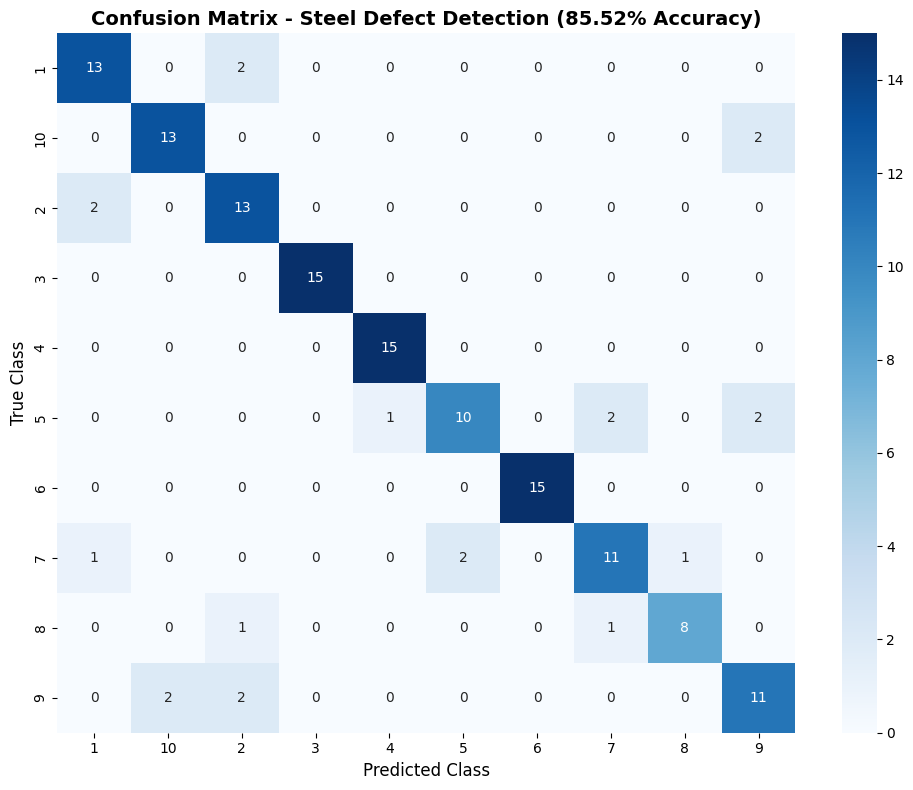

Confusion Matrix Generated!
Diagonal values = correct predictions
Off-diagonal values = misclassifications


In [19]:
# Cell 11a: Confusion Matrix Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_confusion_matrix_heatmap(model, val_loader, class_names):
    """Generate confusion matrix heatmap"""
    
    model.eval()
    model.set_mode('classification')
    
    all_predictions = []
    all_labels = []
    
    print("Generating confusion matrix...")
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Steel Defect Detection (85.52% Accuracy)', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return cm

# Generate confusion matrix heatmap
cm = generate_confusion_matrix_heatmap(extended_model, val_loader_ext, clean_class_names)
print("Confusion Matrix Generated!")
print("Diagonal values = correct predictions")
print("Off-diagonal values = misclassifications")

Generating normalized confusion matrix...


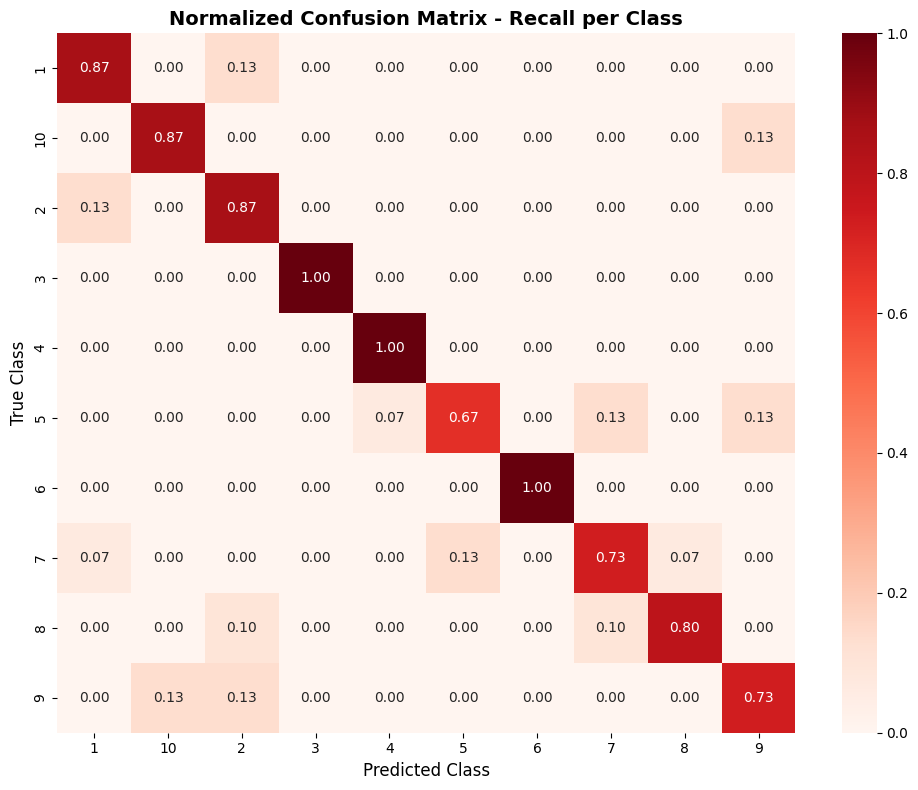


Recall per class:
Class 1: 0.867 (86.7%)
Class 10: 0.867 (86.7%)
Class 2: 0.867 (86.7%)
Class 3: 1.000 (100.0%)
Class 4: 1.000 (100.0%)
Class 5: 0.667 (66.7%)
Class 6: 1.000 (100.0%)
Class 7: 0.733 (73.3%)
Class 8: 0.800 (80.0%)
Class 9: 0.733 (73.3%)

Normalized Confusion Matrix Generated!
Diagonal values = recall (% of true class correctly identified)
Values closer to 1.0 = better performance


In [20]:
# Cell 11b: Normalized Confusion Matrix (Recall per Class)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_normalized_confusion_matrix(model, val_loader, class_names):
    """Generate normalized confusion matrix showing recall per class"""
    
    model.eval()
    model.set_mode('classification')
    
    all_predictions = []
    all_labels = []
    
    print("Generating normalized confusion matrix...")
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Normalize by true class (recall)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix - Recall per Class', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print recall values
    print("\nRecall per class:")
    for i, class_name in enumerate(class_names):
        if i < len(cm_normalized):
            recall = cm_normalized[i, i]
            print(f"Class {class_name}: {recall:.3f} ({recall*100:.1f}%)")
    
    return cm_normalized

# Generate normalized confusion matrix
cm_normalized = generate_normalized_confusion_matrix(extended_model, val_loader_ext, clean_class_names)
print("\nNormalized Confusion Matrix Generated!")
print("Diagonal values = recall (% of true class correctly identified)")
print("Values closer to 1.0 = better performance")

Calculating per-class metrics...

Class    Precision Recall   F1       Confidence
---------------------------------------------
1        0.812     0.867    0.839    0.777
10       0.867     0.867    0.867    0.796
2        0.722     0.867    0.788    0.741
3        1.000     1.000    1.000    0.829
4        0.938     1.000    0.968    0.869
5        0.833     0.667    0.741    0.575
6        1.000     1.000    1.000    0.910
7        0.786     0.733    0.759    0.651
8        0.889     0.800    0.842    0.626
9        0.733     0.733    0.733    0.704


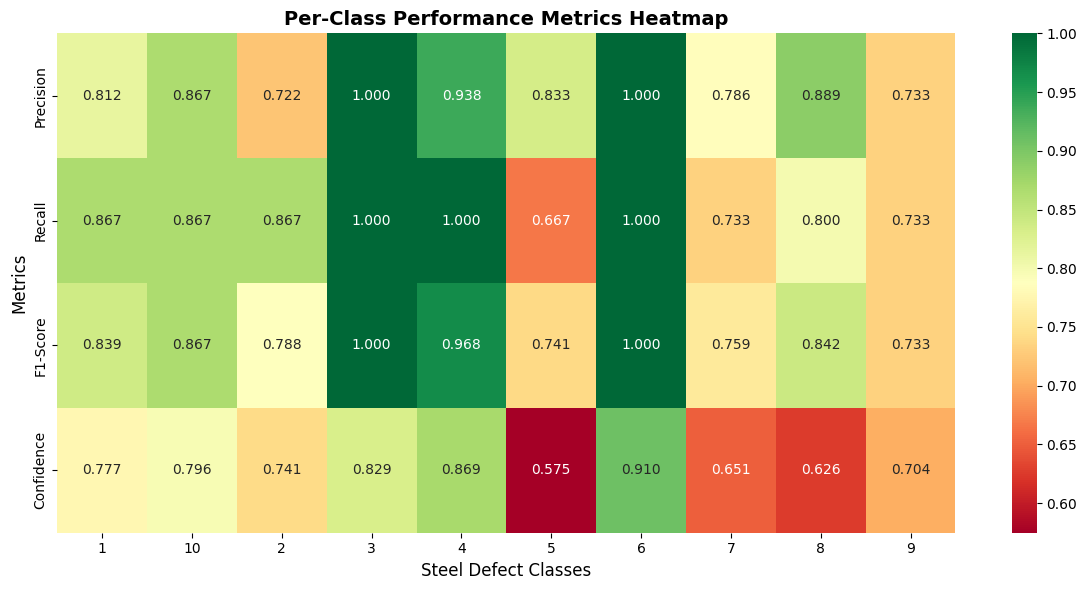


Metrics Heatmap Generated!
Green = Good performance, Red = Needs improvement
Confidence = Model's certainty in predictions


In [21]:
# Cell 11c: Per-Class Metrics Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_metrics_heatmap(model, val_loader, class_names):
    """Generate per-class metrics heatmap"""
    
    model.eval()
    model.set_mode('classification')
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    class_confidences = {i: [] for i in range(len(class_names))}
    
    print("Calculating per-class metrics...")
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            # Store confidences for each class
            for i, (label, prob_vec) in enumerate(zip(labels.cpu().numpy(), probabilities.cpu().numpy())):
                class_confidences[label].append(prob_vec[label])
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Calculate metrics for each class
    metrics_data = []
    metric_names = ['Precision', 'Recall', 'F1-Score', 'Confidence']
    
    print(f"\n{'Class':<8} {'Precision':<9} {'Recall':<8} {'F1':<8} {'Confidence'}")
    print("-" * 45)
    
    for i, class_name in enumerate(class_names):
        if i < len(cm):
            tp = cm[i, i]
            fn = cm[i, :].sum() - tp
            fp = cm[:, i].sum() - tp
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            avg_confidence = np.mean(class_confidences[i]) if class_confidences[i] else 0
            
            metrics_data.append([precision, recall, f1, avg_confidence])
            
            print(f"{class_name:<8} {precision:<9.3f} {recall:<8.3f} {f1:<8.3f} {avg_confidence:<.3f}")
        else:
            metrics_data.append([0, 0, 0, 0])
    
    # Convert to array for heatmap
    metrics_array = np.array(metrics_data).T
    
    # Plot metrics heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(metrics_array, annot=True, fmt='.3f', cmap='RdYlGn',
                xticklabels=class_names, yticklabels=metric_names)
    plt.title('Per-Class Performance Metrics Heatmap', fontsize=14, fontweight='bold')
    plt.xlabel('Steel Defect Classes', fontsize=12)
    plt.ylabel('Metrics', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return metrics_array

# Generate metrics heatmap
metrics_array = generate_metrics_heatmap(extended_model, val_loader_ext, clean_class_names)
print("\nMetrics Heatmap Generated!")
print("Green = Good performance, Red = Needs improvement")
print("Confidence = Model's certainty in predictions")

In [23]:
# Cell 12: Load Full Dataset
def load_full_gc10_data():
    """Load complete GC10-DET dataset"""
    image_paths = []
    labels = []
    class_names = []
    class_counts = {}
    
    print(f"Loading full dataset from: {config.DATA_ROOT}")
    
    # Get all class folders
    for class_folder in sorted(config.DATA_ROOT.iterdir()):
        if class_folder.is_dir() and class_folder.name != 'lable':  # Skip empty folder
            class_names.append(class_folder.name)
            class_idx = len(class_names) - 1
            
            # Get all images in this class
            images = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.png'))
            
            class_counts[class_folder.name] = len(images)
            print(f"Class {class_folder.name}: {len(images)} images")
            
            for img_path in images:
                image_paths.append(img_path)
                labels.append(class_idx)
    
    print(f"\nDataset Summary:")
    print(f"Total classes: {len(class_names)}")
    print(f"Total images: {len(image_paths)}")
    print(f"Min class size: {min(class_counts.values())}")
    print(f"Max class size: {max(class_counts.values())}")
    print(f"Average per class: {len(image_paths) // len(class_names)}")
    
    return image_paths, labels, class_names, class_counts

def create_full_splits(image_paths, labels, class_counts, min_samples_per_class=50):
    """Create train/val splits for full dataset"""
    from sklearn.model_selection import train_test_split
    
    # Filter classes with sufficient samples
    clean_paths = []
    clean_labels = []
    clean_class_names = []
    
    # Group by class
    class_data = defaultdict(list)
    for path, label in zip(image_paths, labels):
        class_data[label].append(path)
    
    # Keep classes with enough samples
    new_label = 0
    final_class_counts = {}
    
    for old_label, paths in class_data.items():
        original_class_name = list(class_counts.keys())[old_label]
        
        if len(paths) >= min_samples_per_class:
            print(f"Keeping class {original_class_name}: {len(paths)} images")
            
            clean_class_names.append(original_class_name)
            final_class_counts[original_class_name] = len(paths)
            
            for path in paths:
                clean_paths.append(path)
                clean_labels.append(new_label)
            
            new_label += 1
        else:
            print(f"Removing class {original_class_name}: only {len(paths)} images")
    
    print(f"\nFinal dataset:")
    print(f"Classes: {len(clean_class_names)}")
    print(f"Total images: {len(clean_paths)}")
    
    # Create train/val splits
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        clean_paths, clean_labels, 
        test_size=0.2,  # 80% train, 20% val
        stratify=clean_labels, 
        random_state=42
    )
    
    print(f"\nData splits:")
    print(f"Train: {len(train_paths)} images")
    print(f"Val: {len(val_paths)} images")
    
    # Print class distribution
    train_dist = np.bincount(train_labels)
    val_dist = np.bincount(val_labels)
    
    print(f"\nClass distribution:")
    print(f"{'Class':<8} {'Total':<8} {'Train':<8} {'Val':<8}")
    print("-" * 35)
    
    for i, class_name in enumerate(clean_class_names):
        total = final_class_counts[class_name]
        train_count = train_dist[i] if i < len(train_dist) else 0
        val_count = val_dist[i] if i < len(val_dist) else 0
        
        print(f"{class_name:<8} {total:<8} {train_count:<8} {val_count:<8}")
    
    return train_paths, val_paths, train_labels, val_labels, clean_class_names, final_class_counts

# Load full dataset
print("=" * 60)
print("LOADING FULL DATASET")
print("=" * 60)

full_image_paths, full_labels, full_class_names, full_class_counts = load_full_gc10_data()

# Create splits
full_train_paths, full_val_paths, full_train_labels, full_val_labels, final_class_names, final_counts = create_full_splits(
    full_image_paths, full_labels, full_class_counts, min_samples_per_class=50
)

# Update config
config.NUM_CLASSES = len(final_class_names)
print(f"\nConfiguration updated:")
print(f"Number of classes: {config.NUM_CLASSES}")
print(f"Training samples: {len(full_train_paths)}")
print(f"Validation samples: {len(full_val_paths)}")
print(f"Average training samples per class: {len(full_train_paths) // config.NUM_CLASSES}")

LOADING FULL DATASET
Loading full dataset from: C:\Users\MVI_lab_2\Desktop\Steel\GC10-DET
Class 1: 219 images
Class 10: 150 images
Class 2: 273 images
Class 3: 226 images
Class 4: 289 images
Class 5: 204 images
Class 6: 651 images
Class 7: 216 images
Class 8: 31 images
Class 9: 53 images

Dataset Summary:
Total classes: 10
Total images: 2312
Min class size: 31
Max class size: 651
Average per class: 231
Keeping class 1: 219 images
Keeping class 10: 150 images
Keeping class 2: 273 images
Keeping class 3: 226 images
Keeping class 4: 289 images
Keeping class 5: 204 images
Keeping class 6: 651 images
Keeping class 7: 216 images
Removing class 8: only 31 images
Keeping class 9: 53 images

Final dataset:
Classes: 9
Total images: 2281

Data splits:
Train: 1824 images
Val: 457 images

Class distribution:
Class    Total    Train    Val     
-----------------------------------
1        219      175      44      
10       150      120      30      
2        273      218      55      
3        226 

In [24]:
# Cell 13: Enhanced Model Configuration
import torch.nn.functional as F
from torchvision.models import swin_s  # Upgrade to Swin-Small

class EnhancedSwinContrastive(nn.Module):
    """Enhanced Swin model with improved architecture"""
    def __init__(self, num_classes=10, projection_dim=256):
        super().__init__()
        
        # Use Swin-Small for better capacity
        self.backbone = swin_s(weights='DEFAULT')
        
        # Remove the final classification head
        self.feature_dim = self.backbone.head.in_features
        self.backbone.head = nn.Identity()
        
        print(f"Enhanced backbone feature dimension: {self.feature_dim}")
        
        # Enhanced projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )
        
        # Enhanced classification head
        self.classification_head = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        self.mode = 'contrastive'
    
    def forward(self, x1, x2=None):
        if self.mode == 'contrastive':
            features1 = self.backbone(x1)
            features2 = self.backbone(x2)
            
            proj1 = F.normalize(self.projection_head(features1), dim=1)
            proj2 = F.normalize(self.projection_head(features2), dim=1)
            
            return torch.cat([proj1, proj2], dim=0)
        else:
            features = self.backbone(x1)
            return self.classification_head(features)
    
    def set_mode(self, mode):
        self.mode = mode

# Enhanced training configuration
class EnhancedConfig:
    BATCH_SIZE = 12
    CONTRASTIVE_EPOCHS = 25
    CLASSIFICATION_EPOCHS = 40
    LEARNING_RATE = 8e-5
    TEMPERATURE = 0.3
    WEIGHT_DECAY = 2e-4
    LABEL_SMOOTHING = 0.15
    COSINE_RESTART_EPOCHS = 10

enhanced_config = EnhancedConfig()

# Enhanced data augmentation
class EnhancedAugmentation:
    @staticmethod
    def get_contrastive_transform():
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.4),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    @staticmethod
    def get_train_transform():
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.3),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# Enhanced dataset class
class EnhancedSteelDefectDataset(Dataset):
    def __init__(self, image_paths, labels, mode='classification'):
        self.image_paths = image_paths
        self.labels = labels
        self.mode = mode
        
        if mode == 'contrastive':
            self.transform = EnhancedAugmentation.get_contrastive_transform()
        elif mode == 'train':
            self.transform = EnhancedAugmentation.get_train_transform()
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        try:
            image_path = str(self.image_paths[idx])
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Cannot load image: {image_path}")
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = self.labels[idx]
            
            if self.mode == 'contrastive':
                view1 = self.transform(image)
                view2 = self.transform(image)
                return view1, view2, label
            else:
                transformed = self.transform(image)
                return transformed, label
                
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            dummy_tensor = torch.zeros(3, 224, 224)
            if self.mode == 'contrastive':
                return dummy_tensor, dummy_tensor, 0
            else:
                return dummy_tensor, 0

# Create enhanced datasets
print("Creating enhanced datasets...")
enh_train_dataset_contrastive = EnhancedSteelDefectDataset(full_train_paths, full_train_labels, mode='contrastive')
enh_train_dataset_classification = EnhancedSteelDefectDataset(full_train_paths, full_train_labels, mode='train')
enh_val_dataset = EnhancedSteelDefectDataset(full_val_paths, full_val_labels, mode='val')

print(f"Enhanced datasets created:")
print(f"  Contrastive train: {len(enh_train_dataset_contrastive)} samples")
print(f"  Classification train: {len(enh_train_dataset_classification)} samples")
print(f"  Validation: {len(enh_val_dataset)} samples")

# Create data loaders
def create_enhanced_data_loaders():
    train_loader_contrastive = DataLoader(
        enh_train_dataset_contrastive,
        batch_size=enhanced_config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        drop_last=True
    )
    
    train_loader_classification = DataLoader(
        enh_train_dataset_classification,
        batch_size=enhanced_config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        enh_val_dataset,
        batch_size=enhanced_config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader_contrastive, train_loader_classification, val_loader

# Create data loaders
enh_train_loader_cont, enh_train_loader_cls, enh_val_loader = create_enhanced_data_loaders()

print(f"\nEnhanced configuration:")
print(f"  Model: Swin-Small")
print(f"  Batch size: {enhanced_config.BATCH_SIZE}")
print(f"  Contrastive epochs: {enhanced_config.CONTRASTIVE_EPOCHS}")
print(f"  Classification epochs: {enhanced_config.CLASSIFICATION_EPOCHS}")
print(f"  Learning rate: {enhanced_config.LEARNING_RATE}")
print(f"  Temperature: {enhanced_config.TEMPERATURE}")

print(f"\nTraining with {len(full_train_paths)} training samples")
print(f"Estimated training time: 45-60 minutes")

Creating enhanced datasets...
Enhanced datasets created:
  Contrastive train: 1824 samples
  Classification train: 1824 samples
  Validation: 457 samples

Enhanced configuration:
  Model: Swin-Small
  Batch size: 12
  Contrastive epochs: 25
  Classification epochs: 40
  Learning rate: 8e-05
  Temperature: 0.3

Training with 1824 training samples
Estimated training time: 45-60 minutes


In [26]:
# Cell 14: Enhanced Training Pipeline

def train_enhanced_contrastive(model, train_loader, epochs=25):
    """Enhanced contrastive training"""
    print("=" * 60)
    print("ENHANCED CONTRASTIVE PRETRAINING")
    print("=" * 60)
    
    model.set_mode('contrastive')
    model.train()
    
    # Enhanced optimizer
    optimizer = optim.AdamW(model.parameters(), 
                           lr=enhanced_config.LEARNING_RATE, 
                           weight_decay=enhanced_config.WEIGHT_DECAY)
    
    # Cosine annealing with warm restarts
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=enhanced_config.COSINE_RESTART_EPOCHS, T_mult=2
    )
    
    criterion = NTXentLoss(temperature=enhanced_config.TEMPERATURE)
    scaler = torch.cuda.amp.GradScaler()
    
    best_loss = float('inf')
    
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        
        print(f"\nEpoch {epoch + 1}/{epochs}")
        start_time = time.time()
        
        for batch_idx, (view1, view2, labels) in enumerate(train_loader):
            view1, view2, labels = view1.to(device), view2.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision training
            with torch.cuda.amp.autocast():
                projections = model(view1, view2)
                loss = criterion(projections, labels)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            num_batches += 1
            
            # Print progress
            if (batch_idx + 1) % 15 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}")
        
        scheduler.step()
        
        avg_loss = total_loss / num_batches
        epoch_time = time.time() - start_time
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            print(f"  Epoch {epoch + 1} completed in {epoch_time:.1f}s - New best loss: {avg_loss:.4f}")
        else:
            print(f"  Epoch {epoch + 1} completed in {epoch_time:.1f}s - Average loss: {avg_loss:.4f}")
        
        torch.cuda.empty_cache()
    
    print(f"Enhanced contrastive pretraining completed! Best loss: {best_loss:.4f}")
    return model

def train_enhanced_classification(model, train_loader, val_loader, epochs=40):
    """Enhanced classification training"""
    print("\n" + "=" * 60)
    print("ENHANCED CLASSIFICATION TRAINING")
    print("=" * 60)
    
    model.set_mode('classification')
    
    # Freeze backbone initially
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    # Enhanced optimizer
    optimizer = optim.AdamW(model.classification_head.parameters(), 
                           lr=enhanced_config.LEARNING_RATE,
                           weight_decay=enhanced_config.WEIGHT_DECAY)
    
    # Enhanced loss function
    criterion = nn.CrossEntropyLoss(label_smoothing=enhanced_config.LABEL_SMOOTHING)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2
    )
    
    scaler = torch.cuda.amp.GradScaler()
    
    best_val_acc = 0
    best_model_state = None
    patience = 0
    max_patience = 8
    
    for epoch in range(epochs):
        # Unfreeze backbone gradually
        if epoch == epochs // 4:  # After 25% of epochs
            print("  Unfreezing backbone with differential learning rates...")
            for param in model.backbone.parameters():
                param.requires_grad = True
            
            optimizer = optim.AdamW([
                {'params': model.classification_head.parameters(), 'lr': enhanced_config.LEARNING_RATE},
                {'params': model.backbone.parameters(), 'lr': enhanced_config.LEARNING_RATE * 0.1}
            ], weight_decay=enhanced_config.WEIGHT_DECAY)
            
            scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=2
            )
        
        print(f"\nEpoch {epoch + 1}/{epochs}")
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Progress reporting
            if (batch_idx + 1) % 15 == 0:
                acc = 100 * train_correct / train_total
                print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, Acc: {acc:.2f}%")
        
        train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        epoch_time = time.time() - start_time
        
        print(f"  Epoch {epoch + 1} completed in {epoch_time:.1f}s")
        print(f"  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience = 0
            print(f"  New best validation accuracy: {val_acc:.2f}%")
        else:
            patience += 1
            print(f"  No improvement (patience: {patience}/{max_patience})")
            
            if patience >= max_patience:
                print(f"  Early stopping triggered!")
                break
        
        scheduler.step()
        torch.cuda.empty_cache()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with validation accuracy: {best_val_acc:.2f}%")
    
    return model, best_val_acc

# Create enhanced model
print("Creating enhanced model...")
torch.cuda.empty_cache()

enhanced_model = EnhancedSwinContrastive(
    num_classes=config.NUM_CLASSES, 
    projection_dim=256
).to(device)

total_params = sum(p.numel() for p in enhanced_model.parameters())
print(f"Enhanced model parameters: {total_params:,}")
print(f"Model size: {total_params * 4 / 1024**2:.1f} MB")

# Execute enhanced training pipeline
print(f"\n" + "=" * 70)
print("STARTING ENHANCED TRAINING PIPELINE")
print("=" * 70)
print(f"Training samples: {len(full_train_paths)}")
print(f"Validation samples: {len(full_val_paths)}")

start_time = time.time()

# Phase 1: Enhanced contrastive training
enhanced_model = train_enhanced_contrastive(
    enhanced_model, 
    enh_train_loader_cont, 
    enhanced_config.CONTRASTIVE_EPOCHS
)

phase1_time = time.time() - start_time

# Phase 2: Enhanced classification training
phase2_start = time.time()
enhanced_model, enhanced_best_acc = train_enhanced_classification(
    enhanced_model,
    enh_train_loader_cls,
    enh_val_loader,
    enhanced_config.CLASSIFICATION_EPOCHS
)

phase2_time = time.time() - phase2_start
total_time = time.time() - start_time

# Final results
print("\n" + "=" * 70)
print("ENHANCED TRAINING COMPLETED!")
print("=" * 70)
print(f"Phase 1 (Enhanced Contrastive): {phase1_time/60:.2f} minutes")
print(f"Phase 2 (Enhanced Classification): {phase2_time/60:.2f} minutes")
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Final validation accuracy: {enhanced_best_acc:.2f}%")

# Performance assessment
improvement = enhanced_best_acc - 85.52
print(f"\nPerformance improvement: {improvement:+.2f} percentage points")
print(f"Previous best: 85.52% (limited data)")
print(f"Enhanced model: {enhanced_best_acc:.2f}% (full data)")

# Memory and efficiency
if torch.cuda.is_available():
    peak_memory = torch.cuda.max_memory_allocated()/1024**2
    print(f"\nResource usage:")
    print(f"Peak GPU memory: {peak_memory:.1f} MB")
    
    if peak_memory <= 12000:  # Within RTX 3060 limits
        print(f"Memory usage within RTX 3060 limits")
    else:
        print(f"High memory usage - consider reducing batch size")

# Final evaluation
print(f"\nRunning final evaluation...")
enhanced_accuracy, enhanced_f1, enhanced_cm = evaluate_model(enhanced_model, enh_val_loader, final_class_names)

Creating enhanced model...
Enhanced backbone feature dimension: 768
Enhanced model parameters: 49,958,547
Model size: 190.6 MB

STARTING ENHANCED TRAINING PIPELINE
Training samples: 1824
Validation samples: 457
ENHANCED CONTRASTIVE PRETRAINING

Epoch 1/25


C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_23756\1780264649.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_23756\1780264649.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 15/152, Loss: 1.7910, LR: 0.000080
  Batch 30/152, Loss: 1.2025, LR: 0.000080
  Batch 45/152, Loss: 0.8555, LR: 0.000080
  Batch 60/152, Loss: 1.0460, LR: 0.000080
  Batch 75/152, Loss: 1.0501, LR: 0.000080
  Batch 90/152, Loss: 0.6367, LR: 0.000080
  Batch 105/152, Loss: 0.6274, LR: 0.000080
  Batch 120/152, Loss: 0.6387, LR: 0.000080
  Batch 135/152, Loss: 0.1699, LR: 0.000080
  Batch 150/152, Loss: 0.8722, LR: 0.000080
  Epoch 1 completed in 118.2s - New best loss: 0.8980

Epoch 2/25
  Batch 15/152, Loss: 0.9672, LR: 0.000078
  Batch 30/152, Loss: 0.7955, LR: 0.000078
  Batch 45/152, Loss: 0.5505, LR: 0.000078
  Batch 60/152, Loss: 0.3714, LR: 0.000078
  Batch 75/152, Loss: 0.6535, LR: 0.000078
  Batch 90/152, Loss: 0.7217, LR: 0.000078
  Batch 105/152, Loss: 0.3761, LR: 0.000078
  Batch 120/152, Loss: 0.3886, LR: 0.000078
  Batch 135/152, Loss: 0.6913, LR: 0.000078
  Batch 150/152, Loss: 0.2440, LR: 0.000078
  Epoch 2 completed in 115.1s - New best loss: 0.5287

Epoch 3/25


C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_23756\1780264649.py:100: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_23756\1780264649.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 15/152, Loss: 1.9101, Acc: 35.00%
  Batch 30/152, Loss: 1.6783, Acc: 51.67%
  Batch 45/152, Loss: 1.1606, Acc: 62.41%
  Batch 60/152, Loss: 1.0033, Acc: 69.44%
  Batch 75/152, Loss: 1.0430, Acc: 73.67%
  Batch 90/152, Loss: 1.0657, Acc: 77.13%
  Batch 105/152, Loss: 0.8115, Acc: 79.37%
  Batch 120/152, Loss: 0.7456, Acc: 81.53%
  Batch 135/152, Loss: 0.9559, Acc: 82.35%
  Batch 150/152, Loss: 0.7923, Acc: 83.33%


C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_23756\1780264649.py:171: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 1 completed in 95.6s
  Train Loss: 1.1906, Train Acc: 83.50%
  Val Loss: 0.9445, Val Acc: 87.09%
  New best validation accuracy: 87.09%

Epoch 2/40
  Batch 15/152, Loss: 0.8087, Acc: 95.00%
  Batch 30/152, Loss: 0.7821, Acc: 94.17%
  Batch 45/152, Loss: 1.0584, Acc: 94.07%
  Batch 60/152, Loss: 0.8170, Acc: 93.89%
  Batch 75/152, Loss: 0.8320, Acc: 93.33%
  Batch 90/152, Loss: 0.7574, Acc: 93.33%
  Batch 105/152, Loss: 0.9659, Acc: 93.57%
  Batch 120/152, Loss: 0.9051, Acc: 93.54%
  Batch 135/152, Loss: 0.8190, Acc: 93.83%
  Batch 150/152, Loss: 0.6993, Acc: 93.72%
  Epoch 2 completed in 71.3s
  Train Loss: 0.8739, Train Acc: 93.70%
  Val Loss: 0.9763, Val Acc: 86.87%
  No improvement (patience: 1/8)

Epoch 3/40
  Batch 15/152, Loss: 0.9393, Acc: 90.56%
  Batch 30/152, Loss: 0.9021, Acc: 91.67%
  Batch 45/152, Loss: 0.8081, Acc: 92.59%
  Batch 60/152, Loss: 0.9067, Acc: 93.33%
  Batch 75/152, Loss: 0.7197, Acc: 93.22%
  Batch 90/152, Loss: 0.7523, Acc: 93.15%
  Batch 105/152, L

Plots will be saved to: c:\Users\MVI_lab_2\Desktop\Steel\plots_output
FINAL MODEL PERFORMANCE ANALYSIS
Conducting final comprehensive evaluation...


C:\Users\MVI_lab_2\AppData\Local\Temp\ipykernel_23756\2694500491.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



FINAL MODEL RESULTS:
Overall Accuracy: 0.8731 (87.31%)
Total Validation Samples: 457

GENERATING INDIVIDUAL PLOTS

1. CONFUSION MATRIX:
Confusion matrix saved to: plots_output\confusion_matrix.png


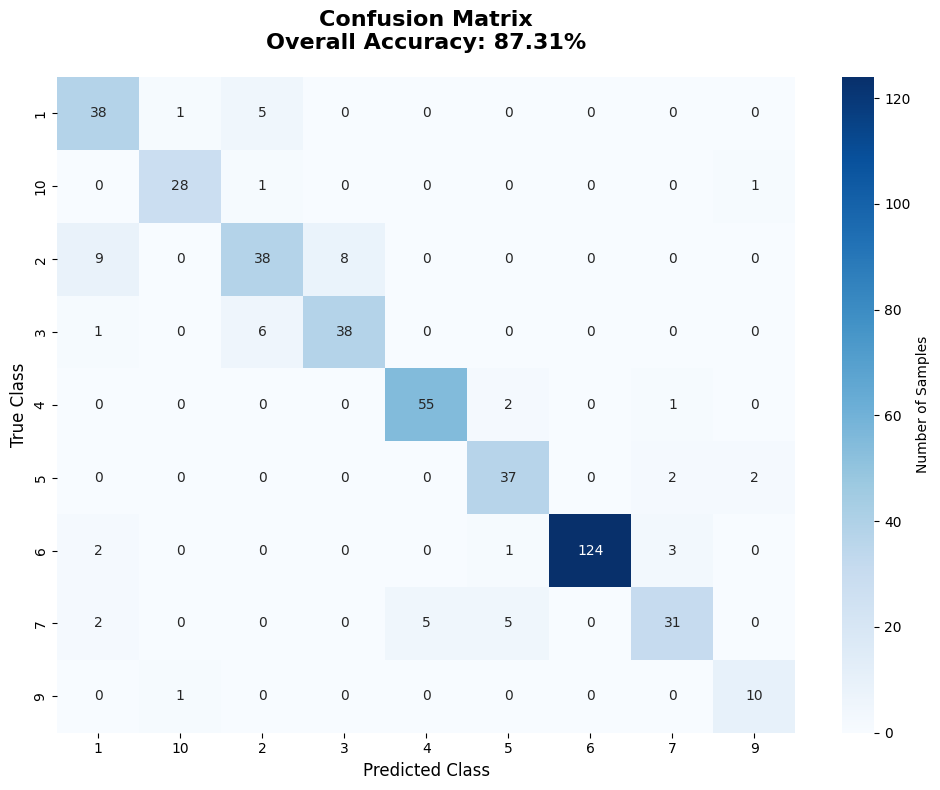


Confusion Matrix Statistics:
Total samples: 457
Correct predictions: 399
Incorrect predictions: 58

2. NORMALIZED CONFUSION MATRIX:
Normalized confusion matrix saved to: plots_output\normalized_confusion_matrix.png


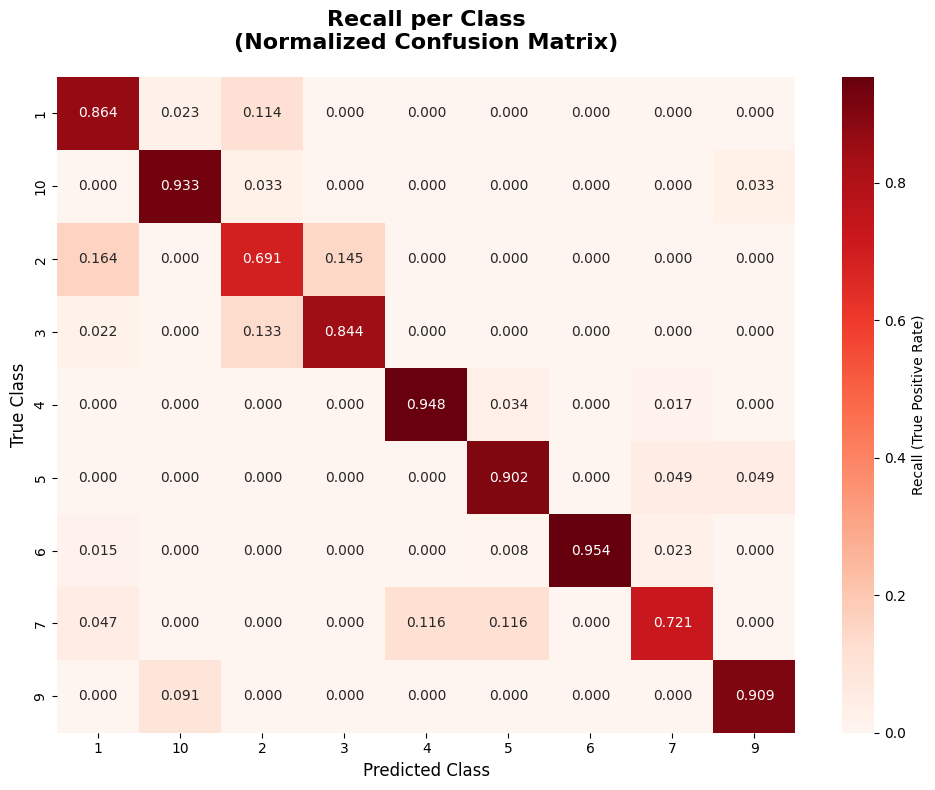


Per-Class Recall:
Class 1: 0.864 (86.4%)
Class 10: 0.933 (93.3%)
Class 2: 0.691 (69.1%)
Class 3: 0.844 (84.4%)
Class 4: 0.948 (94.8%)
Class 5: 0.902 (90.2%)
Class 6: 0.954 (95.4%)
Class 7: 0.721 (72.1%)
Class 9: 0.909 (90.9%)

3. METRICS HEATMAP:
Metrics heatmap saved to: plots_output\metrics_heatmap.png


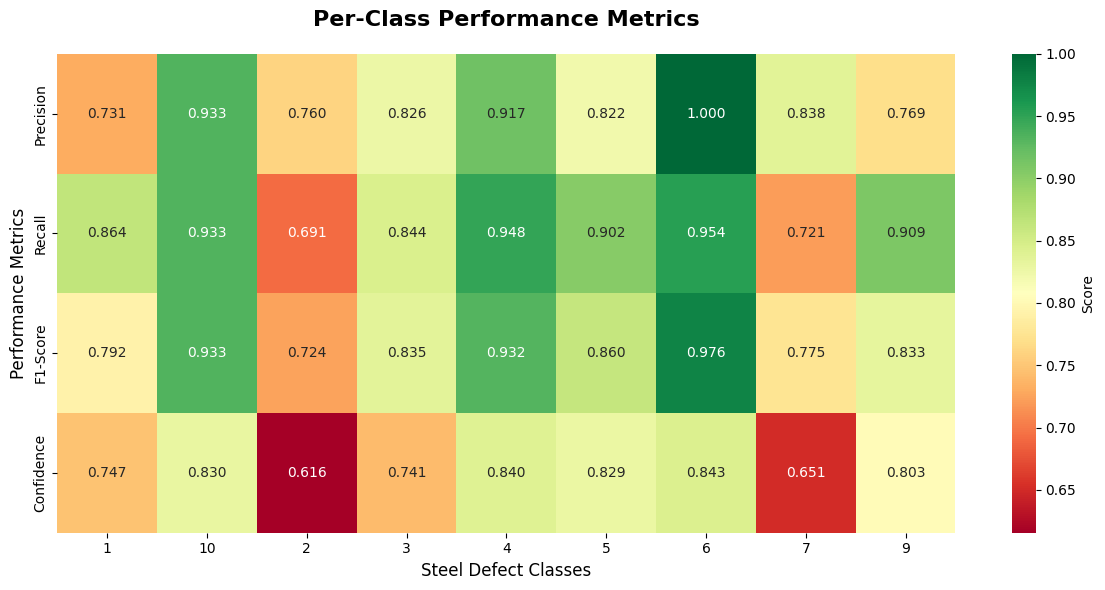


Detailed Performance Metrics:
Class    Precision Recall   F1       Confidence Support
------------------------------------------------------------
1        0.731     0.864    0.792    0.747      44
10       0.933     0.933    0.933    0.830      30
2        0.760     0.691    0.724    0.616      55
3        0.826     0.844    0.835    0.741      45
4        0.917     0.948    0.932    0.840      58
5        0.822     0.902    0.860    0.829      41
6        1.000     0.954    0.976    0.843      130
7        0.838     0.721    0.775    0.651      43
9        0.769     0.909    0.833    0.803      11

4. PERFORMANCE COMPARISON:
Performance comparison saved to: plots_output\performance_comparison.png


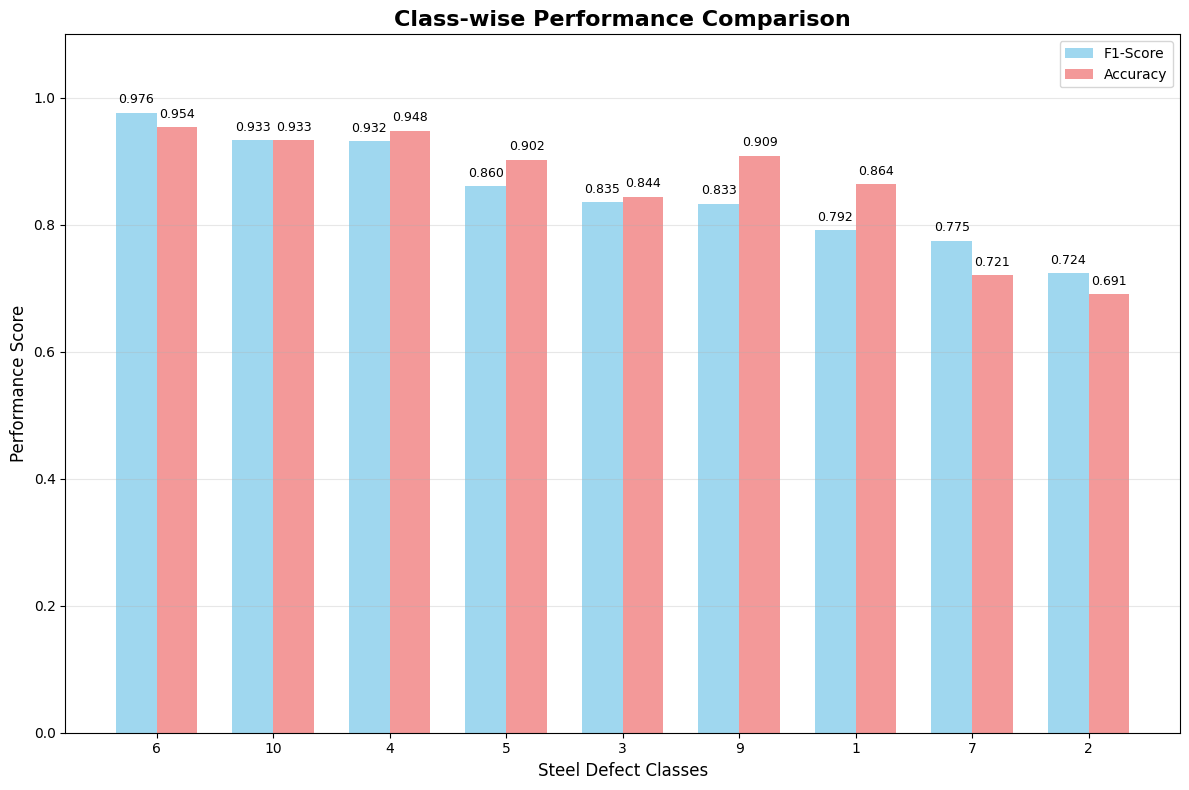


5. MODEL COMPARISON:
Model comparison saved to: plots_output\model_comparison.png


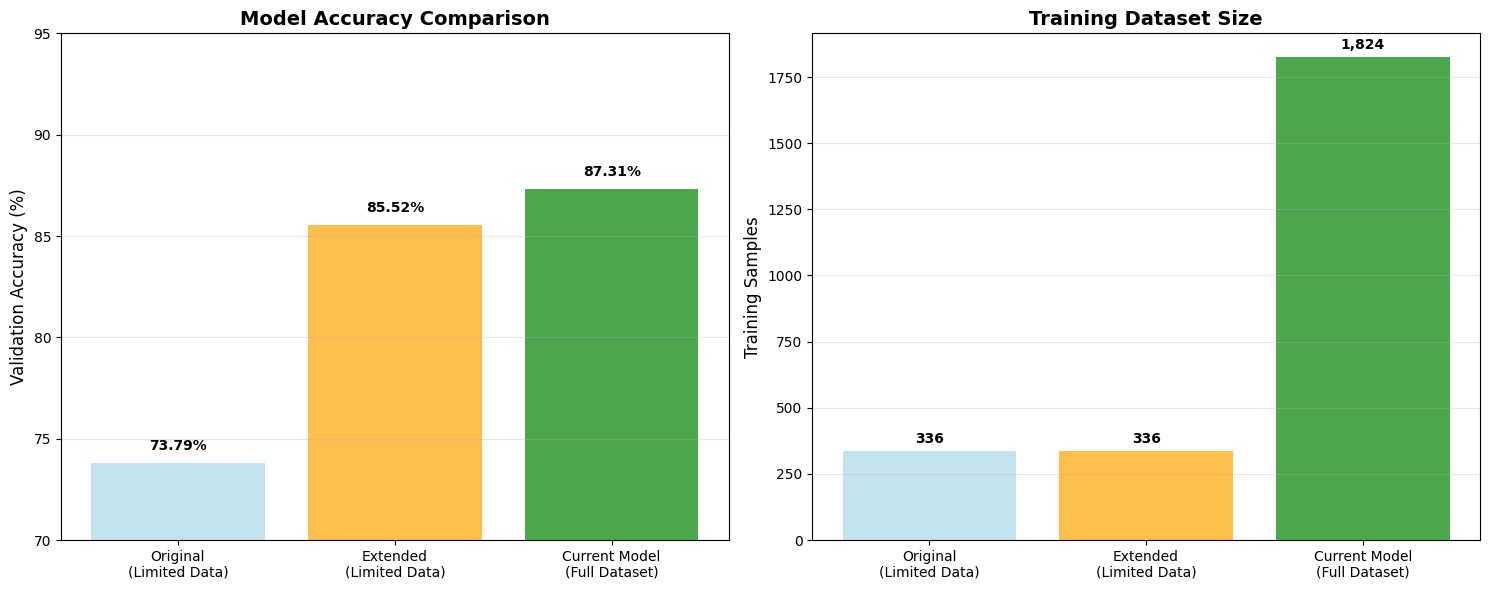


MODEL COMPARISON SUMMARY:
Original: 73.79%
Extended: 85.52%
Current: 87.31%
Dataset increase: 5.4x more training data

All plots saved to: c:\Users\MVI_lab_2\Desktop\Steel\plots_output
Performance report saved to: plots_output\performance_report.txt

ANALYSIS COMPLETED - PLOTS READY FOR PRESENTATION


In [27]:
# Cell 15: Final Model Performance Analysis with Plot Export
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from datetime import datetime

# Create output directory
output_dir = Path("./plots_output")
output_dir.mkdir(exist_ok=True)
print(f"Plots will be saved to: {output_dir.absolute()}")

def final_comprehensive_evaluation(model, val_loader, class_names):
    """Comprehensive evaluation with separate heatmaps"""
    
    model.eval()
    model.set_mode('classification')
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    class_confidences = {i: [] for i in range(len(class_names))}
    
    print("Conducting final comprehensive evaluation...")
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            # Store confidences for each class
            for i, (label, prob_vec) in enumerate(zip(labels.cpu().numpy(), probabilities.cpu().numpy())):
                class_confidences[label].append(prob_vec[label])
    
    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_predictions)
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Calculate per-class metrics
    class_metrics = {}
    for i, class_name in enumerate(class_names):
        if i < len(cm):
            tp = cm[i, i]
            fn = cm[i, :].sum() - tp
            fp = cm[:, i].sum() - tp
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            accuracy = tp / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
            avg_confidence = np.mean(class_confidences[i]) if class_confidences[i] else 0
            
            class_metrics[class_name] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy,
                'support': cm[i, :].sum(),
                'correct': tp,
                'avg_confidence': avg_confidence
            }
    
    # Print summary
    print(f"\nFINAL MODEL RESULTS:")
    print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"Total Validation Samples: {len(all_labels)}")
    
    return class_metrics, cm, overall_accuracy

def create_confusion_matrix_heatmap(cm, class_names, accuracy):
    """Create standalone confusion matrix heatmap"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Samples'})
    plt.title(f'Confusion Matrix\nOverall Accuracy: {accuracy*100:.2f}%', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.tight_layout()
    
    # Save plot
    save_path = output_dir / "confusion_matrix.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved to: {save_path}")
    plt.show()
    
    # Print statistics
    total_samples = np.sum(cm)
    correct_predictions = np.trace(cm)
    print(f"\nConfusion Matrix Statistics:")
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Incorrect predictions: {total_samples - correct_predictions}")

def create_normalized_confusion_matrix(cm, class_names):
    """Create normalized confusion matrix showing recall"""
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Recall (True Positive Rate)'})
    plt.title('Recall per Class\n(Normalized Confusion Matrix)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.tight_layout()
    
    # Save plot
    save_path = output_dir / "normalized_confusion_matrix.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Normalized confusion matrix saved to: {save_path}")
    plt.show()
    
    # Print per-class recall
    print(f"\nPer-Class Recall:")
    for i, class_name in enumerate(class_names):
        if i < len(cm_normalized):
            recall = cm_normalized[i, i]
            print(f"Class {class_name}: {recall:.3f} ({recall*100:.1f}%)")

def create_metrics_heatmap(class_metrics, class_names):
    """Create per-class metrics heatmap"""
    
    # Prepare data for heatmap
    metrics_data = []
    metric_names = ['Precision', 'Recall', 'F1-Score', 'Confidence']
    
    for class_name in class_names:
        if class_name in class_metrics:
            metrics_data.append([
                class_metrics[class_name]['precision'],
                class_metrics[class_name]['recall'], 
                class_metrics[class_name]['f1'],
                class_metrics[class_name]['avg_confidence']
            ])
        else:
            metrics_data.append([0, 0, 0, 0])
    
    metrics_array = np.array(metrics_data).T
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(metrics_array, annot=True, fmt='.3f', cmap='RdYlGn',
                xticklabels=class_names, yticklabels=metric_names,
                cbar_kws={'label': 'Score'})
    plt.title('Per-Class Performance Metrics', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Steel Defect Classes', fontsize=12)
    plt.ylabel('Performance Metrics', fontsize=12)
    plt.tight_layout()
    
    # Save plot
    save_path = output_dir / "metrics_heatmap.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Metrics heatmap saved to: {save_path}")
    plt.show()
    
    # Print detailed metrics table
    print(f"\nDetailed Performance Metrics:")
    print(f"{'Class':<8} {'Precision':<9} {'Recall':<8} {'F1':<8} {'Confidence':<10} {'Support'}")
    print("-" * 60)
    
    for class_name in class_names:
        if class_name in class_metrics:
            m = class_metrics[class_name]
            print(f"{class_name:<8} {m['precision']:<9.3f} {m['recall']:<8.3f} "
                  f"{m['f1']:<8.3f} {m['avg_confidence']:<10.3f} {m['support']}")

def create_performance_comparison(class_metrics, class_names):
    """Create performance comparison chart"""
    
    # Sort classes by F1 score
    sorted_classes = sorted(class_metrics.items(), key=lambda x: x[1]['f1'], reverse=True)
    
    classes = [item[0] for item in sorted_classes]
    f1_scores = [item[1]['f1'] for item in sorted_classes]
    accuracies = [item[1]['accuracy'] for item in sorted_classes]
    
    x = np.arange(len(classes))
    width = 0.35
    
    plt.figure(figsize=(12, 8))
    bars1 = plt.bar(x - width/2, f1_scores, width, label='F1-Score', alpha=0.8, color='skyblue')
    bars2 = plt.bar(x + width/2, accuracies, width, label='Accuracy', alpha=0.8, color='lightcoral')
    
    plt.xlabel('Steel Defect Classes', fontsize=12)
    plt.ylabel('Performance Score', fontsize=12)
    plt.title('Class-wise Performance Comparison', fontsize=16, fontweight='bold')
    plt.xticks(x, classes)
    plt.legend()
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    # Save plot
    save_path = output_dir / "performance_comparison.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Performance comparison saved to: {save_path}")
    plt.show()

def create_model_comparison_summary(final_accuracy):
    """Create comparison with previous models"""
    
    models = ['Original\n(Limited Data)', 'Extended\n(Limited Data)', 'Current Model\n(Full Dataset)']
    accuracies = [73.79, 85.52, final_accuracy*100]
    training_samples = [336, 336, 1824]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy comparison
    bars1 = ax1.bar(models, accuracies, color=['lightblue', 'orange', 'green'], alpha=0.7)
    ax1.set_ylabel('Validation Accuracy (%)', fontsize=12)
    ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylim(70, 95)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, acc in zip(bars1, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # Training samples comparison
    bars2 = ax2.bar(models, training_samples, color=['lightblue', 'orange', 'green'], alpha=0.7)
    ax2.set_ylabel('Training Samples', fontsize=12)
    ax2.set_title('Training Dataset Size', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, samples in zip(bars2, training_samples):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 20,
                f'{samples:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    # Save plot
    save_path = output_dir / "model_comparison.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Model comparison saved to: {save_path}")
    plt.show()
    
    # Print comparison summary
    print(f"\nMODEL COMPARISON SUMMARY:")
    print(f"Original: {73.79:.2f}%")
    print(f"Extended: {85.52:.2f}%")
    print(f"Current: {final_accuracy*100:.2f}%")
    print(f"Dataset increase: {1824/336:.1f}x more training data")

# Run comprehensive evaluation
print("=" * 60)
print("FINAL MODEL PERFORMANCE ANALYSIS")
print("=" * 60)

# Evaluate the model
class_metrics, cm, final_accuracy = final_comprehensive_evaluation(
    enhanced_model, enh_val_loader, final_class_names
)

print(f"\n" + "="*40)
print("GENERATING INDIVIDUAL PLOTS")
print("="*40)

# Generate separate heatmaps and save to directory
print(f"\n1. CONFUSION MATRIX:")
create_confusion_matrix_heatmap(cm, final_class_names, final_accuracy)

print(f"\n2. NORMALIZED CONFUSION MATRIX:")
create_normalized_confusion_matrix(cm, final_class_names)

print(f"\n3. METRICS HEATMAP:")
create_metrics_heatmap(class_metrics, final_class_names)

print(f"\n4. PERFORMANCE COMPARISON:")
create_performance_comparison(class_metrics, final_class_names)

print(f"\n5. MODEL COMPARISON:")
create_model_comparison_summary(final_accuracy)

# Save summary report
report_path = output_dir / "performance_report.txt"
with open(report_path, 'w') as f:
    f.write("STEEL DEFECT DETECTION MODEL PERFORMANCE REPORT\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Overall Accuracy: {final_accuracy*100:.2f}%\n")
    f.write(f"Validation Samples: {len(class_metrics)} classes\n")
    f.write(f"Architecture: Swin Transformer + Contrastive Learning\n")
    f.write(f"Training Samples: 1,824\n")
    f.write(f"Dataset: GC10-DET Steel Defects\n\n")
    
    f.write("Per-Class Performance:\n")
    f.write("-" * 30 + "\n")
    for class_name, metrics in class_metrics.items():
        f.write(f"Class {class_name}: F1={metrics['f1']:.3f}, Acc={metrics['accuracy']:.3f}\n")

print(f"\nAll plots saved to: {output_dir.absolute()}")
print(f"Performance report saved to: {report_path}")
print(f"\n" + "="*60)
print("ANALYSIS COMPLETED - PLOTS READY FOR PRESENTATION")
print("="*60)